In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import yaml

# Import local packages
from examples.norm_norm_diffuse_1d import (
    prior_pdf,
    likelihood_pdf,
    posterior_pdf,
    plot_approximate_posterior,
    approximate_posterior_quantiles_against_x,
    plot_approximate_posterior_quantiles_against_x,
    plot_approximate_posterior_quantiles_diff_against_x,
    plot_approximate_posterior_hist,
    true_posterior,
    simulator,
    snpe_a_posterior_variance,
    plot_snpe_a_posterior_variance,
    plot_sequential_samples
)
from sbc.sbc_tools import plot_sbc_all
results_path = "/Users/Lieve/Documents/Masters Project/SBC-SBI/results/toy_examples/norm_norm_diffuse_1d/npe_a/"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Define prior standard deviation
sigma = 150.

# Amortized NPE-A

In [3]:
amortized_posterior_ID = 0

# Load pre-trained amortized posterior
amortized_posterior_name = f"amortized_posterior{amortized_posterior_ID}"
path_to_amortized_posterior = results_path + amortized_posterior_name + ".pkl"
path_to_amortized_posterior_config = results_path + amortized_posterior_name + ".yaml"
path_to_amortized_posterior_simulations = results_path + amortized_posterior_name + "_simulations" + ".npz"

# Load posterior
with open(path_to_amortized_posterior, "rb") as f:
    amortized_posterior = pickle.load(f)

# Load config
with open(path_to_amortized_posterior_config, "r") as f:
    amortized_posterior_config = yaml.safe_load(f)

# Load samples
amortized_posterior_simulations = np.load(path_to_amortized_posterior_simulations)

print(f"Amortized posterior config:")
amortized_posterior_config

Amortized posterior config:


{'num_components': 1,
 'num_simulations': 20000,
 'sigma': 150.0,
 'simulation_time': 0.0014267080000003318,
 'total_time': 27.053687416,
 'training_time': 27.052260708}

In [4]:
# Turn DirectPosterior object into callable function
def approximate_posterior_amortized(theta, x):
    """
    Output SNPE-A analytical posterior approximation \hat{p}(theta | x)

    theta and x must be 1D torch tensors
    """
    return torch.exp(amortized_posterior.potential(theta, x))

Plot amortized posterior approximation for different $x_\text{observed}$.

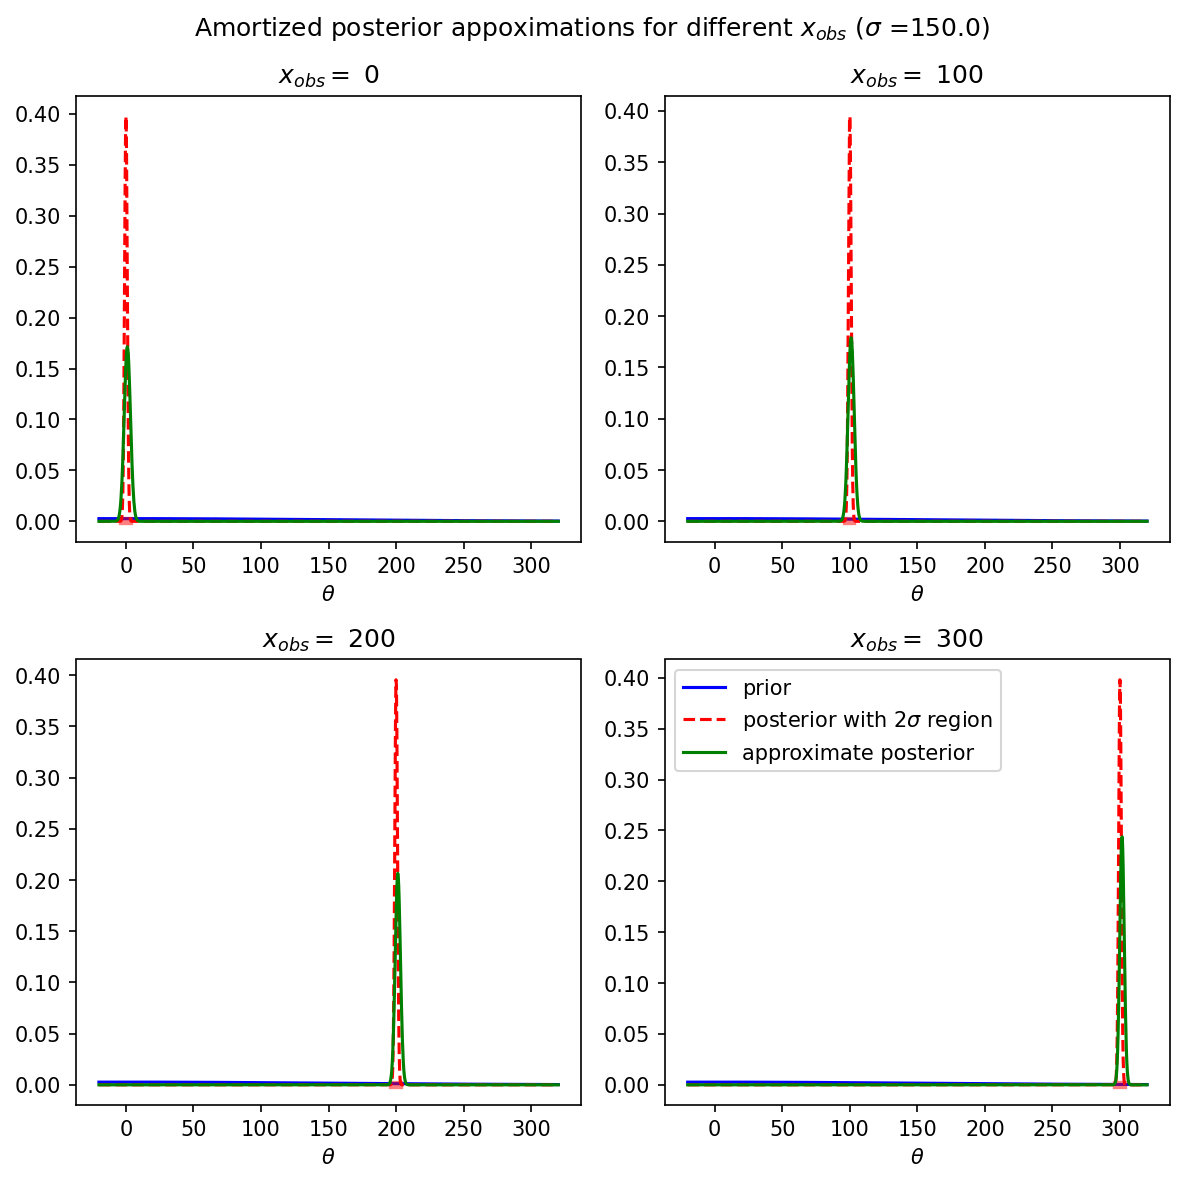

In [5]:
x_observed_values = [0, 100, 200, 300] # Range of observed data
theta_range = torch.linspace(-20,320, 1000).view(-1,1)
title = r"Amortized posterior appoximations for different $x_{obs}$ ($\sigma$ =" + f"{sigma})"
plot_approximate_posterior(approximate_posterior_amortized, prior_pdf, posterior_pdf, theta_range, x_observed_values, sigma, title=title)

Plot amortized posterior approximation for fixed $x_\text{observed}$.

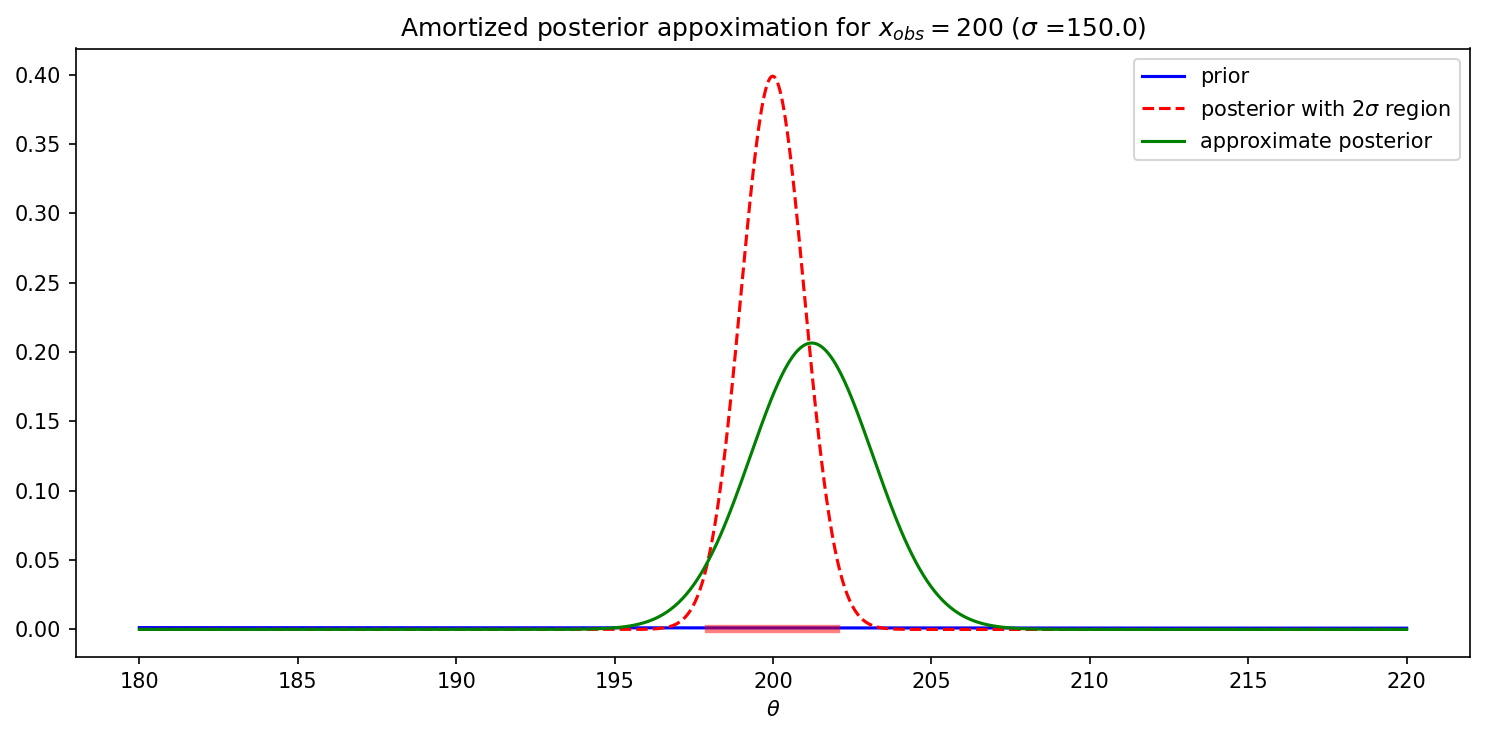

In [6]:
x_observed = 200 # Observed data
theta_range = torch.linspace(180,220,1000).view(-1,1)
title = r"Amortized posterior appoximation for $x_{obs} = $" +f"{x_observed} " + r"($\sigma$ =" + f"{sigma})"
plot_approximate_posterior(approximate_posterior_amortized, prior_pdf, posterior_pdf, theta_range, x_observed, sigma, title=title)

Plot quantiles of amortized posterior for various values of $x_\text{observed}$.

- Without the training samples

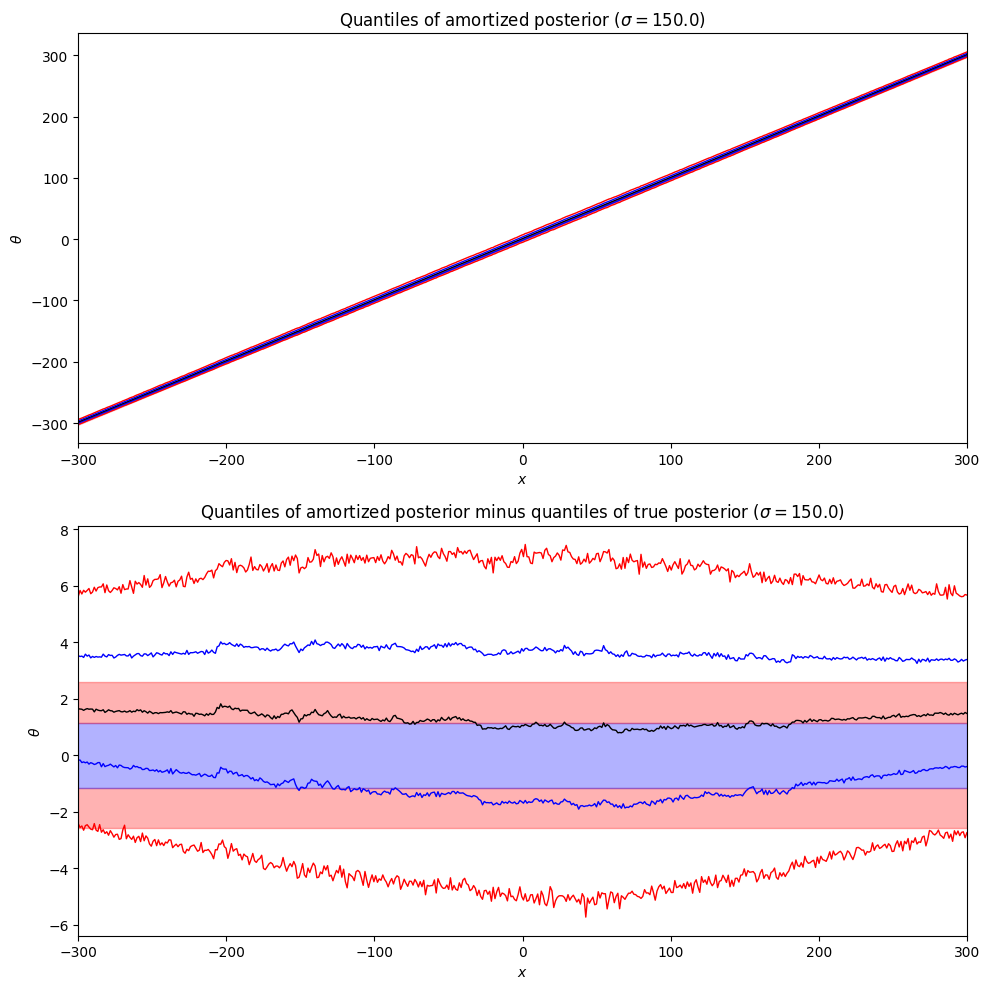

In [7]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(-300,300,500)
quantiles = approximate_posterior_quantiles_against_x(amortized_posterior, x_range)

title = "Quantiles of amortized posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, ax=ax[0])

title = "Quantiles of amortized posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax[1])

plt.tight_layout()
plt.show()

- With the training samples

In [8]:
# Retrieve samples
amortized_posterior_parameter_samples = amortized_posterior_simulations["parameter_samples"].reshape(-1)
amortized_posterior_data_samples = amortized_posterior_simulations["data_samples"].reshape(-1)
amortized_posterior_samples = {"parameter_samples": amortized_posterior_parameter_samples,
                                "data_samples": amortized_posterior_data_samples}

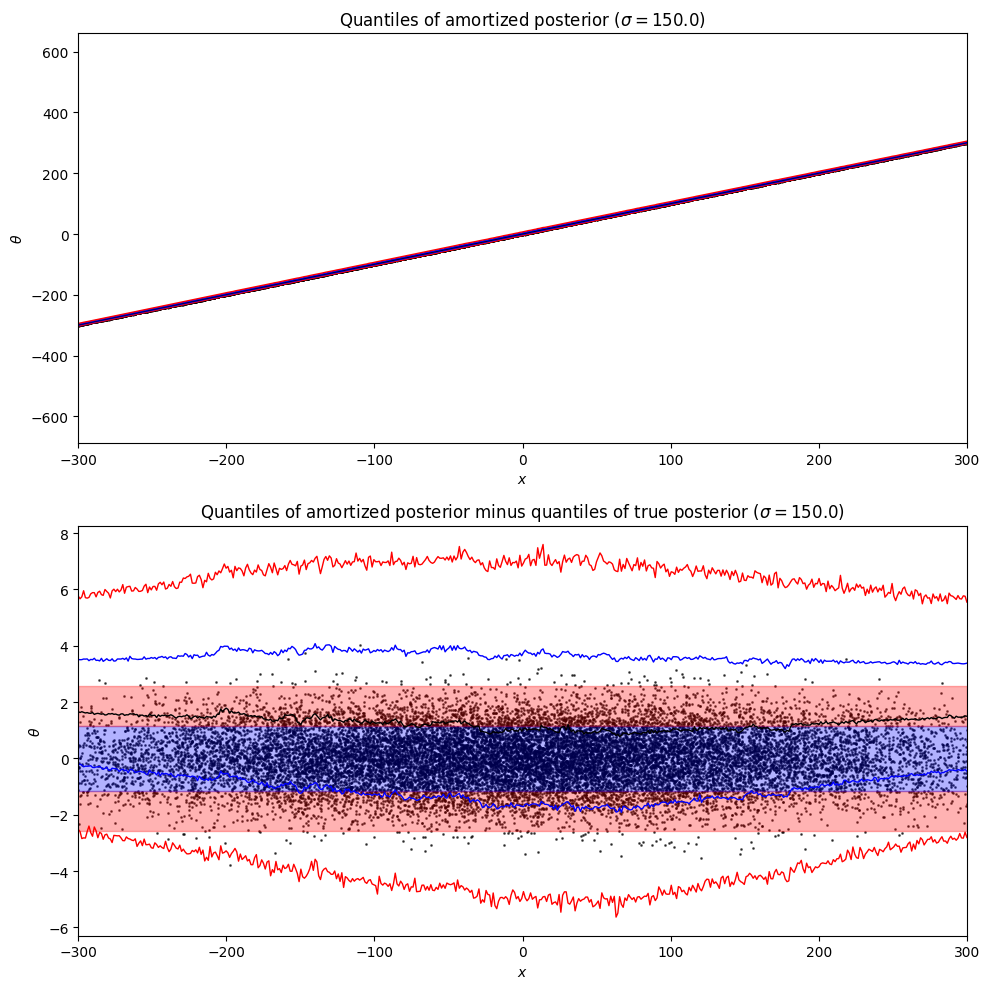

In [9]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(-300,300,500)
quantiles = approximate_posterior_quantiles_against_x(amortized_posterior, x_range)

title = "Quantiles of amortized posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, ax=ax[0], samples=amortized_posterior_samples)

title = "Quantiles of amortized posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax[1], samples=amortized_posterior_samples)

plt.tight_layout()
plt.show()

## SBC on amortized NPE-A

In [10]:
amortized_sbc_ID = 1

# Load pre-trained amortized sbc ranks
amortized_ranks_name = f"amortized_sbc_ranks{amortized_sbc_ID}_amortized_posterior{amortized_posterior_ID}"
path_to_amortized_ranks = results_path + amortized_ranks_name + ".npy"
path_to_amortized_ranks_config = results_path + amortized_ranks_name + ".yaml"
path_to_amortized_ranks_simulations = results_path + amortized_ranks_name + "_simulations" + ".npz"

# Load sbc ranks
amortized_ranks = np.load(path_to_amortized_ranks)

# Load config
with open(path_to_amortized_ranks_config, "r") as f:
    amortized_ranks_config = yaml.safe_load(f)

# Load samples
amortized_ranks_simulations = np.load(path_to_amortized_ranks_simulations)

N_iter = amortized_ranks_config["N_iter"]
N_samp = amortized_ranks_config["N_samp"]

print(f"Amortized SBC config:")
amortized_ranks_config

Amortized SBC config:


{'N_iter': 10000,
 'N_samp': 10000,
 'amortized_posterior_ID': 0,
 'sigma': 150.0,
 'total_sbc_time': 21.723109543323517}

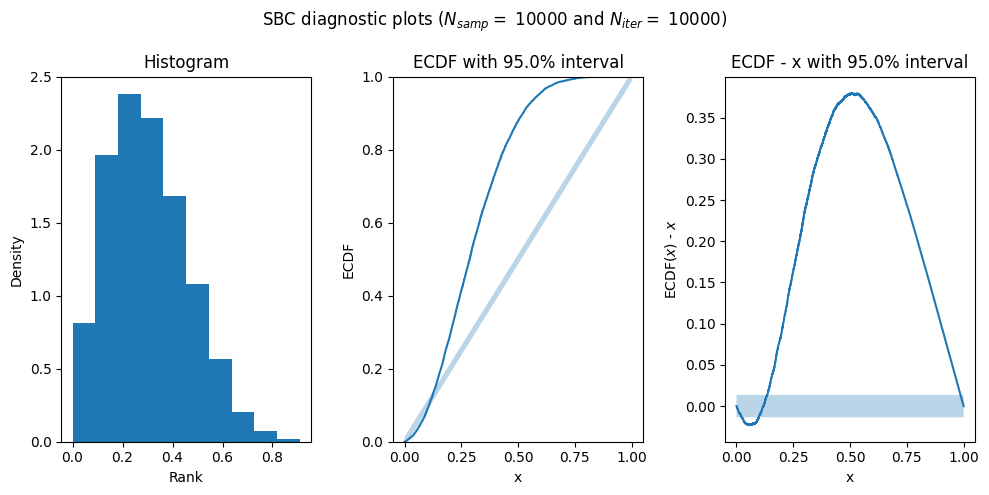

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [11]:
# Plot amortized ranks
plot_sbc_all(ranks=amortized_ranks, N_samp=N_samp)

# Sequential NPE-A (SNPE-A)

We observe that SNPE-A often fails to generate a valid posterior approximation due to the post-hoc correction step in the algorithm. This correction step is required to transform the proposal posterior approximation into the posterior approximation, and fails either:

- During training, because the proposal prior MDN at an intermediate round has a non-PSD covariance matrix.
- After training, because the final approximate posterior MDN has a non-PSD covariance matrix.

Formally, for a given round, let $\tilde{\pi}_\text{proposal prior}(\theta)$ denote the proposal prior and $q_\phi(\theta | x)$ denote the MDN trained on samples from $\tilde{\pi}_\text{proposal prior}(\theta)$. Then, by Proposition 1 from [fast $\epsilon$-free inference], the MDN $q_\phi(\theta | x)$ converges to the proposal posterior in the large-data limit:

$$q_\phi(\theta | x) \to \tilde{\pi}_\text{proposal posterior}(\theta | x) = \frac{\pi(x|\theta) \tilde{\pi}_\text{proposal prior}(\theta)}{\int \pi(x|\theta) \tilde{\pi}_\text{proposal prior}(\theta) d\theta}$$

i.e. the proposal posterior is the posterior of a different model where we take the prior to be the proposal prior. However, since we are interested in inferring the true posterior (i.e. our prior is $\pi(\theta)$ and not $\tilde{\pi}_\text{proposal prior}(\theta)$), we must perform a post-hoc correction to transform $q_\phi(\theta | x)$ from an approximation of the proposal posterior into an approximation of the posterior:

$$\tilde{\pi}(\theta | x) = \frac{\pi(\theta)}{\tilde{\pi}_\text{proposal prior}(\theta)} q_\phi(\theta | x)$$

Following the theory outlined in appendix C of [fast $\epsilon$-free inference], $\tilde{\pi}(\theta | x)$ is also an MDN with covariance matrix approximated by:

$$\Sigma_\text{posterior} \approx (\Sigma_\text{proposal posterior}^{-1} - \Sigma_\text{proposal prior}^{-1})^{-1}$$

which can fail to be positive semi-definite (PSD) if the proposal posterior is less dispersed than the proposal prior. Below, we analyze this in detail for our 1D toy model. Recall that our 1D model (where the covariance matrix equals the variance $\sigma^2$) is defined as follows:

Given a (large) standard deviation $\sigma$ (we take the default to be $150$), we define the following diffuse Gaussian prior centred at $0$:

$$\pi(\theta) = N(\theta ; 0, \sigma^2)$$

We define our simulator as follows

$$\pi(x|\theta) = N(x; \theta , 1) \hspace{5mm} \theta \in \mathbb{R}$$

Suppose we observe some data $x_\text{observed} \in \mathbb{R}$. In this case, we have a true posterior given analytically by

$$\pi(\theta|x_\text{observed}) = N\left(\theta; \frac{\sigma^2}{1+\sigma^2} x_\text{observed}, \frac{\sigma^2}{1+\sigma^2}\right)$$

We then perform (multi-round) SNPE-A on this inference problem to obtain a posterior approximation. Suppose that the proposal prior $\tilde{\pi}_\text{proposal prior}(\theta)$ for some round (which is the posterior approximation from the previous round conditioned on $x_\text{observed}$) has already learned the true posterior mean accurately, with very small variance $\sigma^2_\text{proposal prior} \approx 0$:

$$\tilde{\pi}_\text{proposal prior}(\theta) \sim N\left(\underbrace{\frac{\sigma^2}{1+\sigma^2} x_\text{observed}}_{\text{true posterior mean}}, \sigma^2_\text{proposal prior}\right) \approx N\left(x_\text{observed}, \sigma^2_\text{proposal prior}\right)$$

where we make the approximation $\frac{\sigma^2}{1+\sigma^2} \approx 1$ (which is very accurate for our large $\sigma^2$) for simplicity. The assumption that the proposal prior variance $\sigma^2_\text{proposal prior}$ can become very small is not restrictive and is, in fact, expected in practice for any model, even when the original prior is extremely diffuse (i.e. $\sigma^2$ can be large). This is because the sbi package we use to train the SNPE-A model internally $z$-scores the parameter space $\Theta$ before training the density estimator. In particular, parameters are rescaled using a sample-based estimate of the posterior standard deviation $\hat{\sigma} \approx \sigma$, so that learning and covariance estimation occur in a normalized parameter space. This is done to increase training stability of the MDN's neural networks. As a consequence, variances of proposal priors and proposal posteriors are often small in magnitude in this transformed training space, even when the true prior variance in the original parameterization is large (e.g. $\sigma = 150$). Therefore, regimes in which the proposal prior variance is close to zero naturally arise during later rounds of SNPE-A and should be considered typical rather than pathological.

We now perform a round of SNPE-A that involves generating training samples $\{(\theta_n, x_n)\}_{n=1}^N \sim \tilde{\pi}_\text{proposal prior}(\theta)\pi(x|\theta)$ and then training an MDN $q_\phi(\theta|x)$ to learn the proposal posterior. Asymptotically (see Prop 1 from fast $\epsilon$-free inference) we have

$$q_\phi(\theta|x) \to \tilde{\pi}_\text{proposal posterior}(\theta|x)$$

and we would need to apply the post-hoc posterior correction (multiply by prior and divide by proposal prior) if we wanted to turn $q_\phi(\theta|x)$ into an approximation to the true posterior. Recalling that our likelihood is

$$\pi(x | \theta) \sim N(\theta, 1)$$

we can obtain the exact proposal posterior analytically. When conditioned on $x_\text{observed}$, it is distributed as follows

$$\tilde{\pi}_\text{proposal posterior}(\theta|x) \sim N\left(x_\text{observed}, \frac{\sigma^2_\text{proposal prior}}{1 + \sigma^2_\text{proposal prior}}\right)$$

Using the Taylor expansion of $x \mapsto \frac{x}{1+x}$, we have the following approximation for small $|x|$

$$\frac{x}{1+x} \approx x$$

Which, when applied to our small variance $\sigma^2_\text{proposal prior}$, yields

$$\frac{\sigma^2_\text{proposal prior}}{1+\sigma^2_\text{proposal prior}} \approx \sigma^2_\text{proposal prior}$$

Thus, both the proposal prior and proposal posterior approximately follow the same distribution:

$$N\left(x_\text{observed}, \sigma^2_\text{proposal prior}\right)$$

which is to be expected since our proposal prior was already very concentrated (small $\sigma^2_\text{proposal prior}$) around $x_\text{observed}$, so observing another $x_\text{observed}$ causes a negligible decrease in our uncertainty. During training, the MDN $q_\phi$ approaches the true proposal posterior $\tilde{\pi}_\text{proposal posterior}$ in the limit of infinite data. In practice, however, finite-sample randomness and optimization noise cause the learned variance of $q_\phi$ to deviate from that of the true proposal posterior. In particular, if the variance of the learned MDN is even slightly larger than the variance of the true proposal posterior that it is approximating then, since we proved that the latter is approximately equal to the variance of the proposal prior, we conclude that it is plausible for the trained MDN $q_\phi$ to be more dispersed (larger variance) than the proposal prior (that we used to train $q_\phi$). If this is the case (which isn't guaranteed, just plausible) then applying the posthoc correction will lead to a posterior approximation with negative variance:

$$\sigma^2_\text{posterior approximation} = \frac{1}{\frac{1}{\sigma^2_{q_\phi}} - \frac{1}{\sigma^2_\text{proposal prior}}} < 0$$

which would cause SNPE-A to fail (invalid posterior approximation). This phenomenon would likely occur in later rounds, when the proposal priors begin to "hone in" on an area of the parameter space and become highly concentrated. This suggests that "over training" SNPE-A by running too many sequential rounds will increase the chance of this failure mode.


In [12]:
sequential_posterior_ID = 1

# Load pre-trained posterior
sequential_posterior_name = f"sequential_posterior{sequential_posterior_ID}"
path_to_sequential_posterior = results_path + sequential_posterior_name + ".pkl"
path_to_sequential_posterior_config = results_path + sequential_posterior_name + ".yaml"
path_to_sequential_posterior_simulations = results_path + sequential_posterior_name + "_simulations" + ".npz"

# Load posterior
with open(path_to_sequential_posterior, "rb") as f:
    sequential_posterior = pickle.load(f)

# Load config
with open(path_to_sequential_posterior_config, "r") as f:
    sequential_posterior_config = yaml.safe_load(f)

# Load samples
sequential_posterior_simulations = np.load(path_to_sequential_posterior_simulations)

print(f"Sequential posterior config:")
sequential_posterior_config

Sequential posterior config:


{'num_components': 1,
 'num_sequential_rounds': 4,
 'num_simulations_per_round': 5000,
 'sigma': 150.0,
 'simulation_times': [0.00029895800000012684,
  0.02026870799999969,
  0.004320625000001854,
  0.0014176250000019763],
 'total_time': 22.402110083000004,
 'training_times': [11.749899916999999,
  1.8117632080000021,
  5.9829401250000025,
  2.8312009170000003],
 'x_observed': 200.0}

A bug in the `sbi` package means that we cannot obtain the exact functional form of the sequential posterior. Thus, we must visualize it by generating samples and plotting a histogram.

Below we plot the sequential posterior approximation for different $x_\text{observed}$.

In [13]:
sequential_posterior_samples_x_observed_values = []
try:
    for x in x_observed_values:
        sequential_posterior_samples_x_observed_values.append(sequential_posterior.sample((10000, ), x=x, show_progress_bars=False))
    theta_range = torch.linspace(-400,400, 1000).view(-1,1)
    title=r"Posterior approximation trained sequentially on $x_{obs} = $" + f"{x_observed} for different " + r"$x_{obs}$" + r" ($\sigma = $" + f"{sigma})"
    plot_approximate_posterior_hist(sequential_posterior_samples_x_observed_values, prior_pdf, posterior_pdf, theta_range, x_observed=x_observed_values, sigma=sigma, title=title)
except AssertionError:
    print("SNPE-A FAILED DUE TO NON-PSD MDN COVARIANCE MATRIX!")

SNPE-A FAILED DUE TO NON-PSD MDN COVARIANCE MATRIX!


Plot quantiles of sequential posterior for various values of $x$.

- Without training samples

In [14]:
try:
    x_range = np.linspace(-300,300,500)
    quantiles = approximate_posterior_quantiles_against_x(sequential_posterior, x_range)
    fig, ax = plt.subplots(figsize=(10,10), nrows=2)
    title = "Quantiles of sequential posterior" + r" ($\sigma = $" + f"{sigma})"
    plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, ax=ax[0])
    title = "Quantiles of sequential posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
    plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax[1])
    plt.tight_layout()
    plt.show()
except AssertionError:
    print("SNPE-A FAILED DUE TO NON-PSD MDN COVARIANCE MATRIX!")

SNPE-A FAILED DUE TO NON-PSD MDN COVARIANCE MATRIX!


- With training samples

In [15]:
# Retrieve samples
num_sequential_rounds = sequential_posterior_config["num_sequential_rounds"]
sequential_posterior_parameter_samples = sequential_posterior_simulations[f"parameter_samples_round_{num_sequential_rounds-1}"].reshape(-1)
sequential_posterior_data_samples = sequential_posterior_simulations[f"data_samples_round_{num_sequential_rounds-1}"].reshape(-1)
sequential_posterior_samples = {"parameter_samples": sequential_posterior_parameter_samples,
                                "data_samples": sequential_posterior_data_samples}

try:
    x_range = np.linspace(-300,300,500)
    quantiles = approximate_posterior_quantiles_against_x(sequential_posterior, x_range)
    fig, ax = plt.subplots(figsize=(10,10), nrows=2)
    title = "Quantiles of sequential posterior" + r" ($\sigma = $" + f"{sigma})"
    plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, ax=ax[0], samples=sequential_posterior_samples)
    title = "Quantiles of sequential posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
    plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax[1], samples=sequential_posterior_samples)
    plt.tight_layout()
    plt.show()
except:
    print("SNPE-A FAILED DUE TO NON-PSD MDN COVARIANCE MATRIX!")

SNPE-A FAILED DUE TO NON-PSD MDN COVARIANCE MATRIX!


The SNPE-A posterior approximation failed due to a non-PSD covariance matrix (in this 1D case, a negative variance). Below, we analyze this

/Users/Lieve/Documents/Masters Project/SBC-SBI/src/examples/norm_norm_diffuse_1d.py:385: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_range = torch.tensor(x_range)


<Axes: title={'center': 'Variance of SNPE-A posterior approximation $\\tilde{\\pi}(\\theta | x)$ for different x.'}, xlabel='x', ylabel='Variance'>

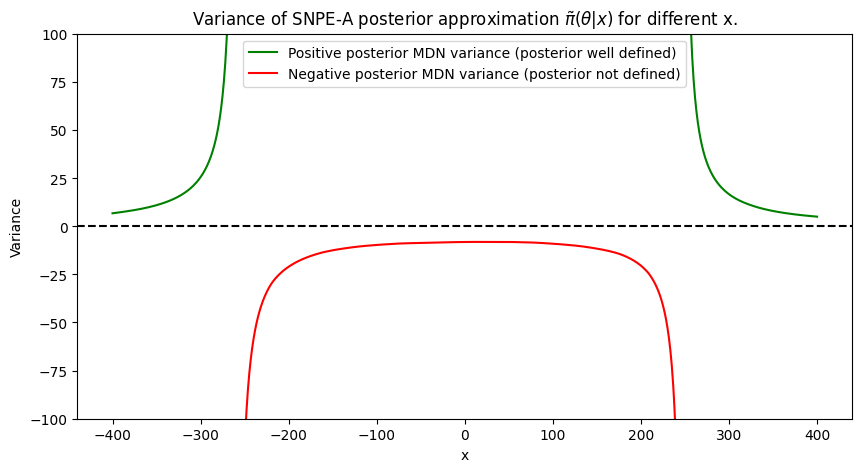

In [16]:
plot_snpe_a_posterior_variance(x_range=torch.linspace(-400,400,1000),
                               sequential_posterior=sequential_posterior,
                               ylim=(-100, 100))

<Axes: title={'center': 'Training samples for each round of SNPE.'}, xlabel='x', ylabel='$\\theta$'>

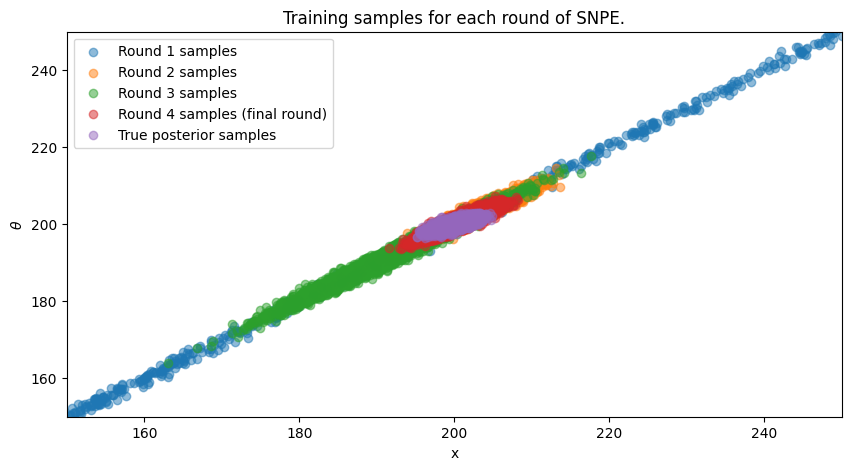

In [17]:
axis_limits = (150, 250)
plot_sequential_samples(sequential_posterior_simulations=sequential_posterior_simulations,
                        sequential_posterior_config=sequential_posterior_config,
                        x_observed=x_observed,
                        sigma=sigma,
                        axis_limits=axis_limits)

<Axes: title={'center': 'Training samples for each round of SNPE.'}, xlabel='x', ylabel='$\\theta$'>

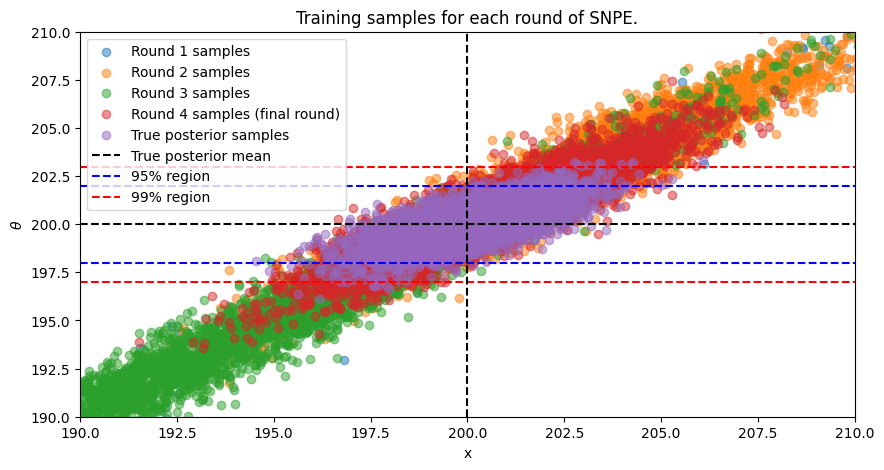

In [18]:
axis_limits = (190, 210)
plot_sequential_samples(sequential_posterior_simulations=sequential_posterior_simulations,
                        sequential_posterior_config=sequential_posterior_config,
                        x_observed=x_observed,
                        sigma=sigma,
                        plot_true_posterior=True,
                        axis_limits=axis_limits)

## SBC on SNPE-A

In [19]:
sequential_sbc_ID = 1

# Load pre-trained sbc ranks
sequential_ranks_name = f"sequential_sbc_ranks{sequential_sbc_ID}"
path_to_sequential_ranks = results_path + sequential_ranks_name + ".npy"
path_to_sequential_ranks_config = results_path + sequential_ranks_name + ".yaml"
path_to_sequential_ranks_simulations = results_path + sequential_ranks_name + "_simulations" + ".npz"

# Load sbc ranks
sequential_ranks = np.load(path_to_sequential_ranks)

# Load config
with open(path_to_sequential_ranks_config, "r") as f:
    sequential_ranks_config = yaml.safe_load(f)

# Load samples
sequential_ranks_simulations = np.load(path_to_sequential_ranks_simulations)

N_iter = sequential_ranks_config["N_iter"]
N_samp = sequential_ranks_config["N_samp"]

num_failed_sbc_rounds = np.sum(np.isnan(sequential_ranks))
print(f"{num_failed_sbc_rounds} failed SBC rounds")

print(f"Sequential SBC config:")
sequential_ranks_config

144 failed SBC rounds
Sequential SBC config:


{'N_iter': 1000,
 'N_samp': 10000,
 'num_components': 1,
 'num_sequential_rounds': 4,
 'num_simulations_per_round': 5000,
 'sigma': 150.0,
 'total_sbc_time': 41978.55242218962}

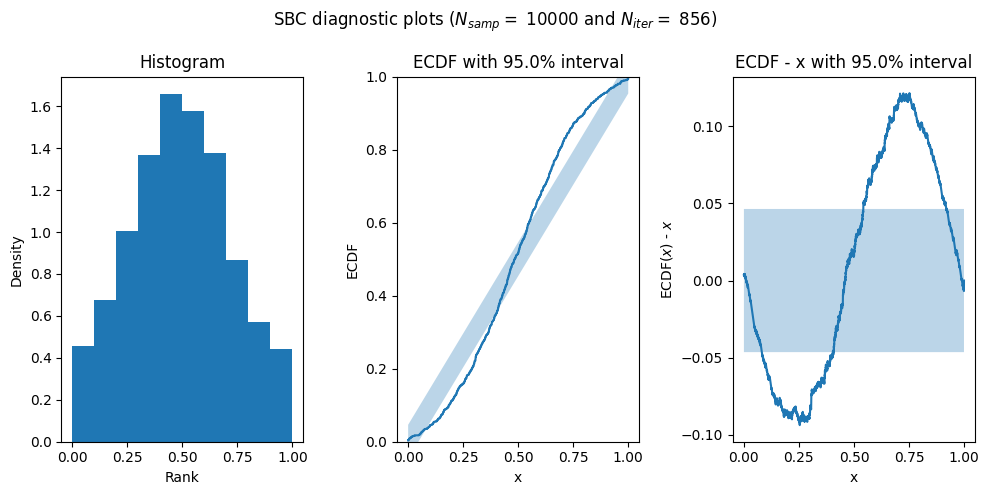

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [20]:
plot_sbc_all(ranks=sequential_ranks, N_samp=N_samp)